## Optimization Project 2
by Álvaro Fernández González and Jaime Hurtado de Mendoza Sastre

In this project the objective is to study different optimization approaches for linear regression models and generalized linear regression models as well as to implement some of them.

Firstly we will ganarate random data that of a linear regression model of 100 predictors. The number of observations we will be dealing with is 1000. After that we obtain the exact coefficients of the model according to the analytical solution which looks as follows when using least squares error as the quantity to minimize.

$$\beta_{ls}=(X^T X)^{-1}X^T y$$

Once we have obtained the true coefficients we will try to estimate them using the software library scipy, specifically its 'minimize' module. From this module we have tried the following algorithms: Nelder-Mead, Powell, Conjugate Gradient and Newton Conjugate Gradient. This algorithms will be explained in the section where we have used them.

After that we have implemented four minimization methods which are Gradient Descent, Newton, Quasi-Newton and Stochastic Gradient Descent. These four methods will be explained in their corresponding sections.

Finally, we have used Pyomo to formulate the Least Absolute Regression and Gurobi to solve it.


In [53]:
## Generate the random data
import numpy as np
np.random.seed(42) ## To be able to recreate the results
# (b - a) * random_sample() + a -> Random number between b = -5 and a = 5
betas = -10 * np.random.random_sample((101,1)) + 5
# The intercept column
x0 = np.ones([1000,1])
# Random values for the variables between 0 and 10 following a uniform distribution
x1 = np.random.uniform(0,10,([1000,100]))
x = np.concatenate([x0, x1], axis=1)
error = np.random.normal(0,1,[1000,1])
y = np.dot(x,betas)+error
y.shape

(1000, 1)

a) Estimate the value of the regression coefficients by implementing the analytical solution.

The formulation for the analytical solution is presented in the introductory section.

In [141]:
## Helper function to compare the value of the Betas
import matplotlib.pyplot as plt
def compare(betas1, betas2):
    # compare the coefficients
    plt.plot(betas1[:,0]-betas2[:,0], color='g')

    barWidth = 0.4
    x1 = np.asarray([i for i in range(101)])
    x2 = barWidth*np.ones(101)+x1

    plt.bar(x1, betas1[:,0], color='b', width=barWidth, edgecolor='white', label='Mod1')
    plt.bar(x2, betas2[:,0], color='r', width=barWidth, edgecolor='white', label='Mod2')

    plt.legend()
    plt.title("Coefficient comparison")
    plt.xlabel('Variables', fontweight='bold')
    plt.ylabel('Values of the coefficients', fontweight='bold')
    fig = plt.gcf()
    fig.set_size_inches(15,5)
    plt.show()

(101, 1)


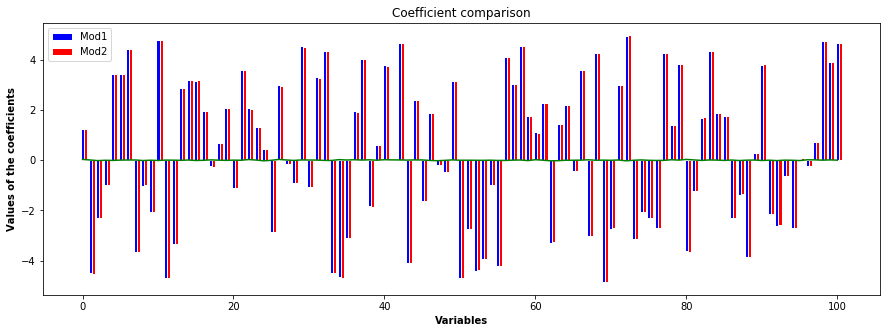

In [142]:
from numpy.linalg import inv
beta_ls_exact = np.dot(np.dot(inv(np.dot(x.T,x)),x.T),y)
print(beta_ls_exact.shape)
compare(betas, beta_ls_exact)

b) Estimate the value of the regression coefficients by using the function minimize from the Python module Scipy.optimize. Trying out at least 4 solvers.

In [90]:
## Least squares of a given model (function to be minimized during the optimization process)
def least_sq_reg(beta_ls, x, y):
    beta_ls=np.matrix(beta_ls)
    z=y-np.dot(x,beta_ls.T)
    return np.dot(z.T,z)

#### Nelder-Mead
- Explanation of the algorithm.

Nelder-Mead is just an implementation of the Simplex Algorithm. The precise explanation of how it is implemented can be found in [1]

/Users/Jaime/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


Optimization terminated successfully.
         Current function value: 6007523.277145
         Iterations: 300523
         Function evaluations: 317634
time elapsed= 72.82189700000004
(101, 1)


/Users/Jaime/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


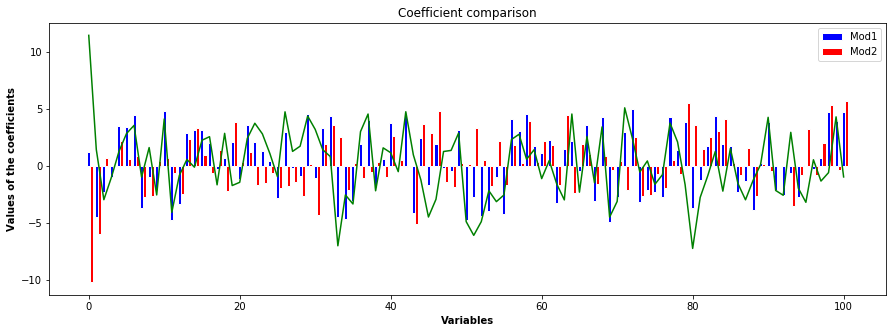

error= 1.0057983823386052


In [130]:
from scipy.optimize import minimize
import time

beta_ls0 = np.zeros(101) # Initial guess for the coefficients
time_start = time.clock()
res = minimize(least_sq_reg, beta_ls0, args=(x, y), method='Nelder-Mead', options={'disp': True, 'maxiter': 500000})
nfev = res.nfev
nit = res.nit

time_elapsed = (time.clock() - time_start)
print('time elapsed=',time_elapsed)
betas_res = res.x
betas_res = np.reshape(betas_res, (101,1))
print(betas_res.shape)
compare(beta_ls_exact, betas_res) 
print('error=',np.linalg.norm(beta_ls_exact.T-res.x,ord=2)/np.linalg.norm(beta_ls_exact.T,ord=2))

In [121]:
print(res)

 final_simplex: (array([[-10.20025398,  -5.94234725,   0.65680626, ...,   5.33666309,
         -0.38060526,   5.65038043],
       [-10.20025361,  -5.94233705,   0.65681316, ...,   5.33666356,
         -0.38059839,   5.650388  ],
       [-10.20025433,  -5.94233994,   0.65680692, ...,   5.33666086,
         -0.38058736,   5.65037806],
       ...,
       [-10.20024012,  -5.94234161,   0.65681119, ...,   5.33667165,
         -0.38059694,   5.65039056],
       [-10.20025637,  -5.94234377,   0.65679636, ...,   5.33667022,
         -0.38060175,   5.65038085],
       [-10.20025376,  -5.94233239,   0.6568062 , ...,   5.33666552,
         -0.38059866,   5.65038434]]), array([6007523.27714456, 6007523.27715005, 6007523.27715017,
       6007523.27715487, 6007523.27715524, 6007523.27715646,
       6007523.27715708, 6007523.27715746, 6007523.2771604 ,
       6007523.27716121, 6007523.27716366, 6007523.27716755,
       6007523.27717005, 6007523.2771704 , 6007523.2771706 ,
       6007523.27717194, 600

#### Powell
- Explanation of the algorithm (https://www.ime.unicamp.br/~sandra/MS612/handouts/Fletcher1965.pdf)

/Users/Jaime/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


Optimization terminated successfully.
         Current function value: 11841.293549
         Iterations: 386
         Function evaluations: 352542
time elapsed= 71.81745899999999
(101, 1)


/Users/Jaime/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


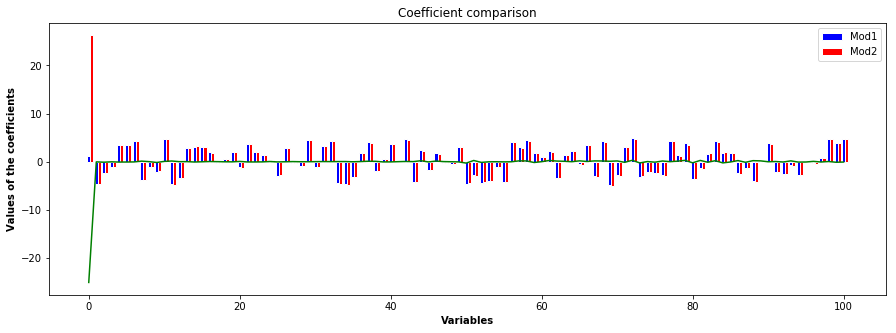

error= 0.8324670666879059


In [147]:
beta_ls0 = np.zeros(101) # Initial guess for the coefficients
time_start = time.clock()
res = minimize(least_sq_reg, beta_ls0, args=(x, y), method='Powell', options={'disp': True, 'maxiter': 500000})
time_elapsed = (time.clock() - time_start)

nfev = res.nfevd
nit = res.nit

print('time elapsed=',time_elapsed)
betas_res = np.asarray(res.x)
betas_res = np.reshape(betas_res, (101,1))
print(betas_res.shape)
compare(beta_ls_exact, betas_res) 
print('error=',np.linalg.norm(beta_ls_exact.T-res.x,ord=2)/np.linalg.norm(beta_ls_exact.T,ord=2))

#### Conjugate Gradient
- Explanation of the algorithm

In [179]:
# The conjugate gradient method needs the first derivative of the objective function
def least_sq_reg_der(beta_ls,X,Y):
    beta_ls = np.matrix(beta_ls)
    pp = -2*np.dot((Y-np.dot(X,beta_ls.T)).T,X)
    aa = np.squeeze(np.asarray(pp))
    return aa


/Users/Jaime/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/Users/Jaime/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


         Current function value: 982.017753
         Iterations: 167
         Function evaluations: 451
         Gradient evaluations: 440
time elapsed= 0.1742500000000291
(101, 1)


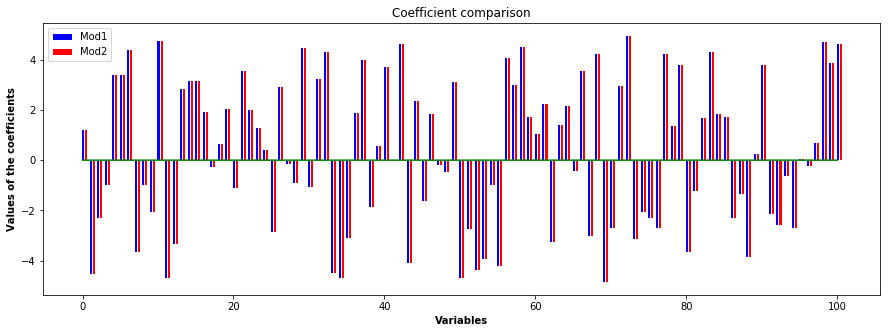

error= 1.1711409865903599e-06


In [151]:
beta_ls0 = np.zeros(101) # Initial guess for the coefficients
time_start = time.clock()
res = minimize(least_sq_reg, beta_ls0, jac=least_sq_reg_der, args=(x, y), method='CG', options={'disp': True})
time_elapsed = (time.clock() - time_start)

nfev = res.nfev
nit = res.nit

print('time elapsed=',time_elapsed)
betas_res = res.x
betas_res = np.reshape(betas_res, (101,1))
print(betas_res.shape)
compare(beta_ls_exact, betas_res) 
print('error=',np.linalg.norm(beta_ls_exact.T-res.x,ord=2)/np.linalg.norm(beta_ls_exact.T,ord=2))

#### Newton Conjugate Gradient
- Explanation of the algorithm

In [152]:
# Even though the second derivative is not a requisite (as isn't the firs derivative in the previous case) we will provide it
def least_sq_reg_hess(beta_ls,X,Y):
    ss=2*np.dot(np.transpose(X),X)
    return ss

/Users/Jaime/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/Users/Jaime/anaconda3/envs/python3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:507: RuntimeWarning: Method CG does not use Hessian information (hess).
  RuntimeWarning)
/Users/Jaime/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


         Current function value: 982.017753
         Iterations: 167
         Function evaluations: 451
         Gradient evaluations: 440
time elapsed= 0.14109799999982897
(101, 1)


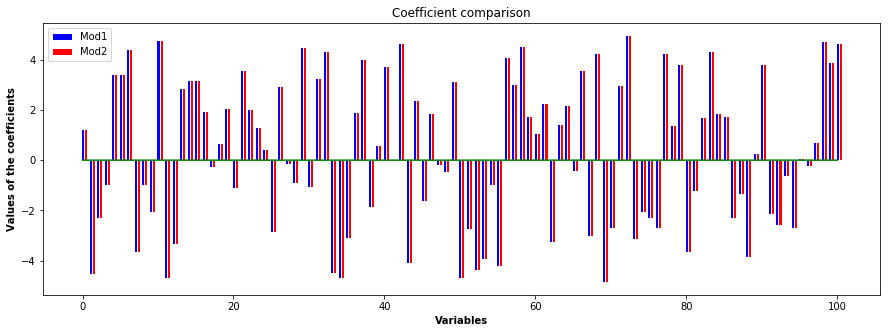

error= 1.1711409865903599e-06


In [153]:
beta_ls0 = np.zeros(101) # Initial guess for the coefficients
time_start = time.clock()
res = minimize(least_sq_reg, beta_ls0, jac=least_sq_reg_der, hess=least_sq_reg_hess, args=(x, y), method='CG', options={'disp': True})
time_elapsed = (time.clock() - time_start)

nfev = res.nfev
nit = res.nit

print('time elapsed=',time_elapsed)
betas_res = res.x
betas_res = np.reshape(betas_res, (101,1))
print(betas_res.shape)
compare(beta_ls_exact, betas_res) 
print('error=',np.linalg.norm(beta_ls_exact.T-res.x,ord=2)/np.linalg.norm(beta_ls_exact.T,ord=2))

c) Estimate the value of the regression coefficients by implementing:

i. Gradient Method.

ii. Newton Method.

iii. Quasi-Newton Method.

iv. Stochastic Gradient Method.

#### Gradient Method implementation

(101,)
0


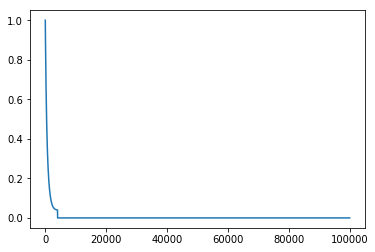

In [228]:
def gradDesc(x, y, obj_fun, jac, lr = 0.001, iterations = 100000, tol = 0.04):
    beta_lsg = np.zeros(101)
    OF_iter=np.zeros(iterations)
    tol_hist=np.zeros(iterations)
    print_step = iterations/10
    for it in range(iterations):
        if (it%print_step == 0):
            print(it)
        grad = jac(beta_lsg, x, y)
        sigma = 0.1
        beta = 0.1
        while (obj_fun(beta_lsg+lr*(-grad), x, y) > least_sq_reg(beta_lsg,x,y)+lr*sigma*np.dot(grad,-grad)):
            lr=lr*beta
        beta_lsg = beta_lsg+lr*(-grad)
        OF_iter[it] = obj_fun(beta_lsg,x,y)
        tol_val = np.linalg.norm(beta_ls_exact.T-beta_lsg,ord=2)/np.linalg.norm(beta_ls_exact.T,ord=2)
        tol_hist[it] = tol_val
        if (tol_val < tol):
            break
    return (beta_lsg, OF_iter, tol_hist)

time_start = time.clock()
(beta_gd, of_gd, tol_gd) = gradDesc(x, y, least_sq_reg, least_sq_reg_der)
time_elapsed = (time.clock() - time_start)
print('time elapsed=',time_elapsed)

plt.plot(tol_gd)

0.03999981584496086


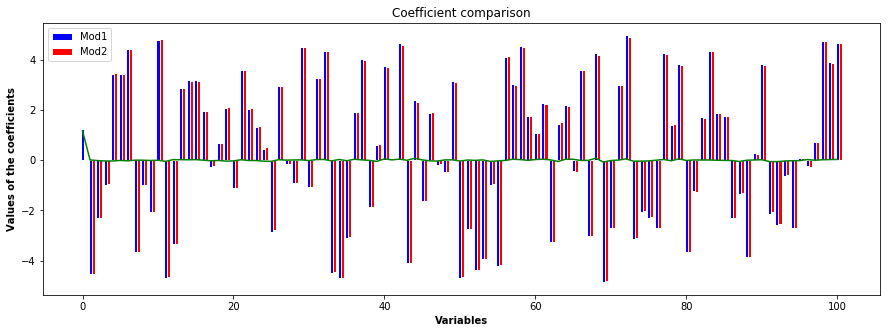

In [229]:
print(min(tol_gd[tol_gd>0]))
compare(beta_ls_exact, np.reshape(beta_gd, (101,1)))

#### Newton Method implementation

/Users/Jaime/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


0
time elapsed= 15.197057999999743


/Users/Jaime/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


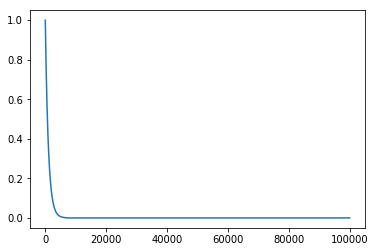

In [298]:
def newton(x, y, obj_fun, jac, hess, lr = 0.001, iterations = 100000, tol = 0.001):
    beta_lsn = np.zeros(101)
    OF_iter=np.zeros(iterations)
    tol_hist=np.zeros(iterations)
    print_step = iterations/10
    for it in range(iterations):
        if (it%print_step == 0):
            print(it)
        grad = jac(beta_lsn,x,y)
        hessian = hess(beta_lsn,x,y)
        ddirect = -np.dot(np.linalg.inv(hessian),grad)
        ###########################
        sigma=0.1
        beta=0.1
        #alpha=1
        while (obj_fun(beta_lsn+lr*ddirect,x,y) > obj_fun(beta_lsn, x, y)+lr*sigma*np.dot(grad,ddirect)):
            lr=lr*beta
        ###########################
        beta_lsn=beta_lsn+lr*ddirect
        OF_iter[it] = obj_fun(beta_lsn,x,y)
        tol_val = np.linalg.norm(beta_ls_exact.T-beta_lsn,ord=2)/np.linalg.norm(beta_ls_exact.T,ord=2)
        tol_hist[it] = tol_val
        if (tol_val < tol):
            break
    return (beta_lsn, OF_iter, tol_hist)

time_start = time.clock()
(beta_nw, OF_nw, tol_nw) = newton(x, y, least_sq_reg, least_sq_reg_der, least_sq_reg_hess)
time_elapsed = (time.clock() - time_start)
print('time elapsed=',time_elapsed)

plt.plot(tol_nw)

0.0009993007201693934


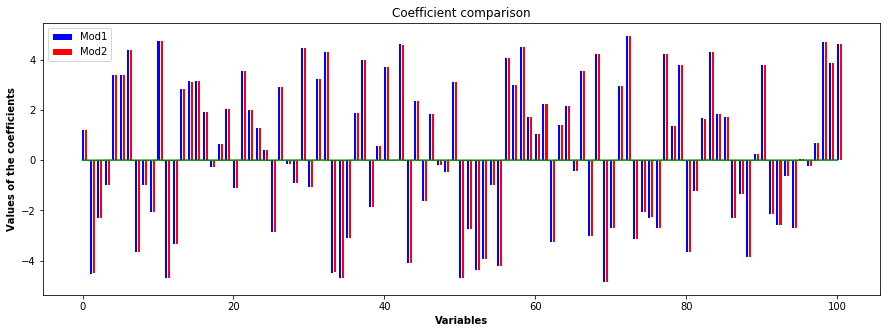

In [299]:
print(min(tol_nw[tol_nw>0]))
compare(beta_ls_exact, np.reshape(beta_nw, (101,1)))

#### Quasi-Newton Method

In [328]:
def hessianPowell(beta, next_beta, grad, next_grad, hess_prev):
    s = next_beta - beta
    y = next_grad - grad
    ybs = y-np.dot(hess_prev,s)
    h = hess_prev+(np.dot(ybs,np.transpose(ybs))/np.dot(np.transpose(ybs),s))
    return h

def hessianBFGS(beta, next_beta, grad, next_grad, hess_prev):
    s = next_beta - beta
    y = next_grad - grad
    bs = np.dot(hess_prev,s)
    yy = np.dot(y,np.transpose(y))
    h = hess_prev-(np.dot(bs,np.transpose(bs))/np.dot(np.transpose(s),bs))+(yy/np.dot(np.transpose(y),s))
    return h

In [332]:
def quasiNewton(x, y, obj_fun, jac, lr = 0.001, iterations = 12000, tol = 0.01, method="powell"):
    print(method)
    beta_lsq = np.zeros(101)
    OF_iter=np.zeros(iterations)
    tol_hist=np.zeros(iterations)
    print_step = iterations/10
    hessian = np.identity(101)
    grad_prev = jac(beta_lsq,x,y)
    beta_prev = beta_lsq
    for it in range(iterations):
        if (it%print_step == 0):
            print(it)
        grad = jac(beta_lsq,x,y)
        ddirect = -np.dot(np.linalg.inv(hessian),grad)
        ###########################
        sigma=0.1
        beta=0.1
        #alpha=1
        while (obj_fun(beta_lsq+lr*ddirect,x,y) > obj_fun(beta_lsq, x, y)+lr*sigma*np.dot(grad,ddirect)):
            lr=lr*beta
        ###########################
        beta_prev = beta_lsq
        grad_prev = grad
        beta_lsq=beta_lsq+lr*ddirect
        grad = jac(beta_lsq,x,y)
        if (method == 'powell'):
            hessian = hessianPowell(beta_prev, beta_lsq, grad_prev, grad, hessian)
        elif (method == 'bfgs'):
            hessian = hessianBFGS(beta_prev, beta_lsq, grad_prev, grad, hessian)
        OF_iter[it] = obj_fun(beta_lsq,x,y)
        tol_val = np.linalg.norm(beta_ls_exact.T-beta_lsq,ord=2)/np.linalg.norm(beta_ls_exact.T,ord=2)
        tol_hist[it] = tol_val
        if (tol_val < tol):
            break
    return (beta_lsq, OF_iter, tol_hist, hessian)
    
time_start = time.clock()
(beta_qn_powell, OF_qn_powell, tol_qn_powell, hessian_powell) = quasiNewton(x, y, least_sq_reg, least_sq_reg_der, method='powell')
time_elapsed = (time.clock() - time_start)
print('time elapsed powell=',time_elapsed)

time_start = time.clock()
(beta_qn_bfgs, OF_qn_bfgs, tol_qn_bfgs, hessian_bfgs) = quasiNewton(x, y, least_sq_reg, least_sq_reg_der, method='bfgs')
time_elapsed = (time.clock() - time_start)
print('time elapsed bfgs=',time_elapsed)

/Users/Jaime/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


powell
0
1200
2400
3600
4800
6000
7200
8400
9600
10800


/Users/Jaime/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/Jaime/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


time elapsed powell= 15.652466000000004
bfgs
0
1200
2400
3600
4800
6000
7200
8400
9600
10800
time elapsed bfgs= 16.097936000000118


/Users/Jaime/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


0.7346389991199364


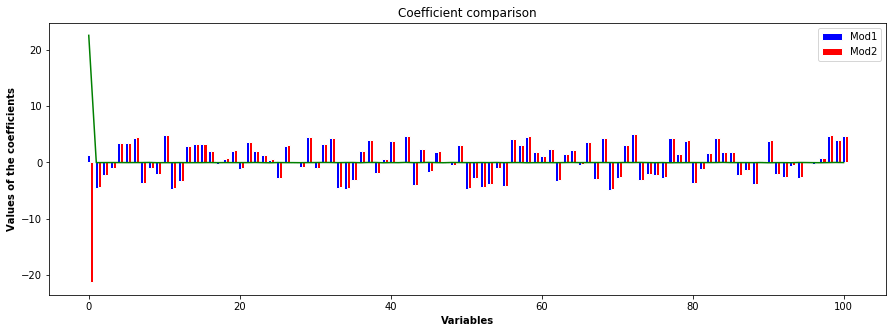

In [333]:
print(min(tol_qn_powell[tol_qn_powell>0]))
compare(beta_ls_exact, np.reshape(beta_qn_powell, (101,1)))

0.7346389990081286


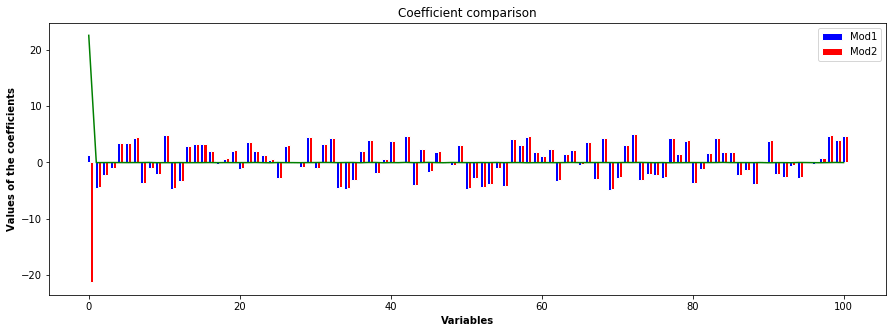

In [334]:
print(min(tol_qn_bfgs[tol_qn_bfgs>0]))
compare(beta_ls_exact, np.reshape(beta_qn_bfgs, (101,1)))

#### Stochastic Gradient

In [371]:
def stochGradDesc(x, y, obj_fun, jac, lr = 1, iterations = 1000000, tol = 0.04):
    beta_lssg = np.ones(101)
    OF_iter=np.zeros(iterations)
    tol_hist=np.zeros(iterations)
    print_step = iterations/10
    for it in range(iterations):
        if (it%print_step == 0):
            print(it)
        index = np.random.choice(x.shape[0], 1)[0]
        grad = jac(beta_lssg, np.reshape(x[index], (1,101)), y[index])
        sigma = 0.1
        beta = 0.1
        while (obj_fun(beta_lssg+lr*(-grad), x, y) > least_sq_reg(beta_lssg,x,y)+lr*sigma*np.dot(grad,-grad)):
            lr=lr*beta
        beta_lssg = beta_lssg+lr*(-grad)
        OF_iter[it] = obj_fun(beta_lssg,x,y)
        tol_val = np.linalg.norm(beta_ls_exact.T-beta_lssg,ord=2)/np.linalg.norm(beta_ls_exact.T,ord=2)
        tol_hist[it] = tol_val
        if (tol_val < tol):
            break
    return (beta_lssg, OF_iter, tol_hist)

time_start = time.clock()
(beta_sgd, of_sgd, tol_sgd) = stochGradDesc(x, y, least_sq_reg, least_sq_reg_der)
time_elapsed = (time.clock() - time_start)
print('time elapsed=',time_elapsed)

/Users/Jaime/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


0
100000
200000
300000
400000
500000
600000
700000
800000
900000
time elapsed= 539.5449429999994


/Users/Jaime/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


0.9752304789175108


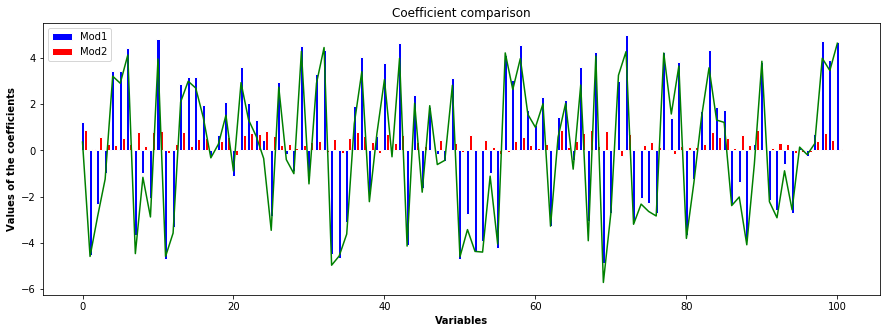

In [372]:
print(min(tol_sgd[tol_sgd>0]))
compare(beta_ls_exact, np.reshape(beta_sgd, (101,1)))

In [373]:
print(np.sqrt(least_sq_reg(x=x,y=y,beta_ls=np.reshape(beta_ls_exact,(1,101)))))
print(np.sqrt(least_sq_reg(x=x,y=y,beta_ls=beta_sgd)))

[[31.33716249]]
[[2723.94812932]]


d) Linear formulation for Least Absolute Regression

In [378]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
opt = SolverFactory("gurobi")

model = AbstractModel()

model.nobs = RangeSet(1,1000)
model.nvars = RangeSet(1,101)
model.t = Var(model.nobs, domain=NonNegativeReals)
model.betas = Var(model.nvars, domain=Reals)

def obj(model):
    return sum(model.t[i] for i in model.nobs)
model.obj = Objective(rule=obj, sense=minimize)

def constraints_up(model, i):
    return  model.t[i] + sum(x[i-1][j-1]*model.betas[j] for j in model.nvars) >= y[i-1]
model.contraints_up = Constraint(model.nobs, rule=constraints_up)

def constraints_down(model, i):
    return sum(x[i-1][j-1]*model.betas[j] for j in model.nvars) - model.t[i] <= y[i-1] 
model.contraints_down = Constraint(model.nobs, rule=constraints_down)

modelInstance = model.create_instance()
modelResults = opt.solve(modelInstance)

print(modelResults)


Problem: 
- Name: x1102_copy
  Lower bound: 761.527908092
  Upper bound: 761.527908092
  Number of objectives: 1
  Number of constraints: 2001
  Number of variables: 1102
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 1102
  Number of nonzeros: 204001
  Sense: minimize
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 0.787955999374
  Error rc: 0
  Time: 1.2393317222595215
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [389]:
betas_gurobi = np.zeros((101, 1))
for i in range(101):
    betas_gurobi[i] = modelInstance.betas[i+1].value

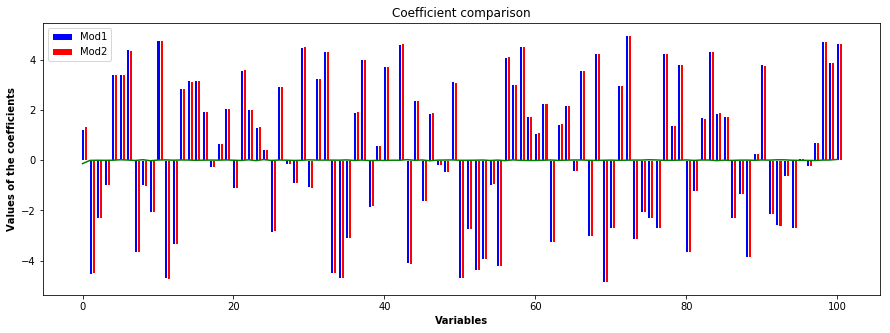

In [390]:
compare(beta_ls_exact, betas_gurobi)

In [387]:
beta_ls_exact.shape

(101, 1)

In [388]:
betas_gurobi.shape

(1, 101)

#### References

[1] (https://pdfs.semanticscholar.org/15b4/c4aa7437df4d032c6ee6ce98d6030dd627be.pdf)